In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates
from sklearn.decomposition import PCA
import pickle


In [2]:
#Loading Time data from WAVE dataset to interpolate to the same time interval.



# Define the root directory and the file name prefix
roots = "C:/Users/guioc/Documents/Art1/SoundSSC/Output_Data/"
file_names = ['wave_dt_stamp.pkl', 'wave_dt.pkl']
# Dictionary to store the already processed velocity data
data = {}
# Loop through the file names and load the data using pickle
for file_name in file_names:
    with open(roots + file_name, 'rb') as file:
        data[file_name.replace('.pkl', '')] = pickle.load(file)
# Saving time variable
t_II = data['wave_dt_stamp'][:]
t = data['wave_dt'][:]


In [3]:
# Load the data
met_data = np.genfromtxt('C:/Users/guioc/Documents/Art1/SoundSSC/Raw_Data/SIMCOSTA_RS-4_MET_2019-02-19_2021-04-03.tab', delimiter='\t')

# Filter out rows with missing or non-numeric data
mask = np.logical_not(np.isnan(met_data).any(axis=1))
met_data = met_data[mask]

# Define the time range to be used
start_idx = np.where(met_data[:,0] == 2020)[0][0]
end_idx = np.where(met_data[:,0] == 2021)[0][0]
met_data = met_data[start_idx:end_idx]

# Initialize lists
met_t = []
Wind_U = []
Wind_V = []
time_II = []

# Process each row in the data
for row in met_data:
    # Adjust the time variable
    data = datetime(int(row[0]), int(row[1]), int(row[2]), int(row[3]), int(row[4]), int(row[5]))
    met_t.append(data)
    tsh_timestamp = data.timestamp()  # Convert to timestamp
    time_II.append(tsh_timestamp)

    # Calculate the U and V components of wind
    dirc = row[13]
    vel = row[11]
    U = np.sin(np.radians(dirc)) * vel
    V = np.cos(np.radians(dirc)) * vel
    
    Wind_U.append(U)
    Wind_V.append(V)

In [4]:
Wind_U_intp = np.interp(t_II, time_II, Wind_U)
Wind_V_intp = np.interp(t_II, time_II, Wind_V)

Angle with true north: -42.41 degrees


Text(0.5, 1.0, 'PCA of U and V Components')

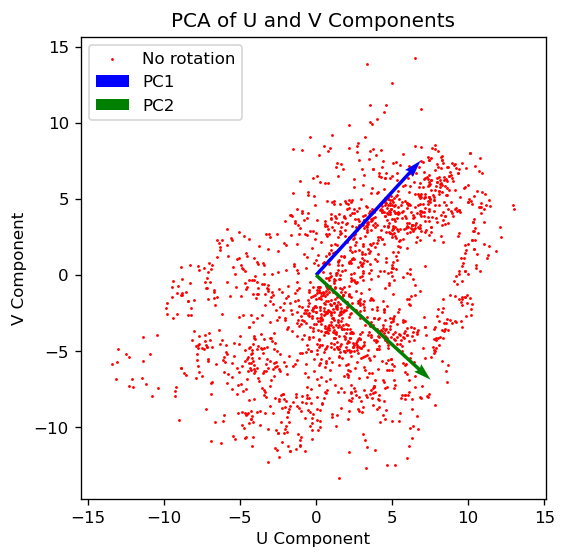

In [5]:
# Assuming v1_cut and v2_cut are numpy arrays
v1 = Wind_U_intp  # Flattening the array, adjust indices if necessary
v2 = Wind_V_intp  # Flattening the array, adjust indices if necessary

# Organizing the data for PCA
data = np.vstack((v1, v2)).T

# Applying PCA
pca = PCA(n_components=2)
pca.fit(data)
components = pca.components_

# Principal components
pc1 = components[0]
pc2 = components[1]

# Calculating the angle between the first principal component and true north (y-axis)
angle_with_north = np.arctan2(pc1[1], pc1[0])  # In radians
angle_with_north_deg = np.degrees(angle_with_north) - 90  # Converting to degrees and adjusting for true north

print(f"Angle with true north: {angle_with_north_deg:.2f} degrees")


fig, ax = plt.subplots(figsize=(5,5), dpi = 120)

# Plotting the data
ax.scatter(v1, v2, c='r', s=0.5, label='No rotation')

# Plotting the principal components
origin = [0], [0]  # Origin for the vectors
ax.quiver(*origin, *pc1, color='b', scale=3, label='PC1')
ax.quiver(*origin, *pc2, color='g', scale=3, label='PC2')
ax.axis('equal')
ax.set_xlabel('U Component')
ax.set_ylabel('V Component')
ax.legend()
ax.set_title('PCA of U and V Components')




In [6]:
# Rotating the velocity data by 57 degrees.
M = np.sqrt(Wind_U_intp**2 + Wind_V_intp**2)
UV_dir = np.arctan2(Wind_V_intp / M, Wind_U_intp / M) 
UV_dir_degrees = np.rad2deg(UV_dir) 

np.shape(UV_dir_degrees)          

U_spin = np.zeros(len(M))
V_spin = np.zeros(len(M))

# Rotating the velocity components
for j in range(len(M)):
    if M[j] != 0:
        rot_ang = (UV_dir_degrees[j] - 42.41) % 360
        
        U_spin[j] = M[j] * np.cos(np.radians(rot_ang))
        V_spin[j] = M[j] * np.sin(np.radians(rot_ang))


C:\Users\guioc\AppData\Local\Temp\ipykernel_91292\2536923970.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(Wind_V_intp/10, Wind_U_intp/10, c='r', cmap=plt.cm.jet, s=5, label='without rotation')
C:\Users\guioc\AppData\Local\Temp\ipykernel_91292\2536923970.py:17: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(V_spin/10, U_spin/10, c='b', cmap=plt.cm.jet, s=5, label='with rotation')


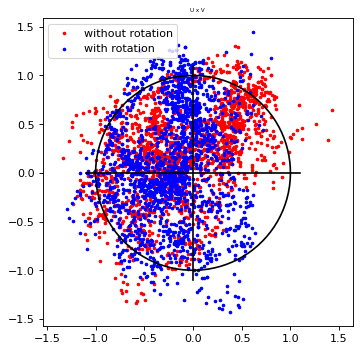

In [7]:
fig, ax = plt.subplots(figsize=(5,5), dpi = 80)

# Define a circle for reference
n = np.linspace(0, 2*np.pi, 100)
circ_x = np.sin(n)
circ_y = np.cos(n)

# Plot the circle and axes
ax.plot(circ_x, circ_y, 'k')
ax.plot([0, 0], [-1.1, 1.1], 'k')  # Y-axis
ax.plot([-1.1, 1.1], [0, 0], 'k')  # X-axis
ax.axis('equal')  # Equal scaling for both axes

plt.title("U x V", fontsize=5)
# Plot the data points (before and after rotation) on the circle
ax.scatter(Wind_V_intp/10, Wind_U_intp/10, c='r', cmap=plt.cm.jet, s=5, label='without rotation')
ax.scatter(V_spin/10, U_spin/10, c='b', cmap=plt.cm.jet, s=5, label='with rotation')

# Show the legend
ax.legend()


In [8]:
# Save the rotated wind components (U and V) to files
with open(roots+'Wind_U_spin.pkl', 'wb') as file:
    pickle.dump(U_spin, file)  # U_spin contains the rotated U component of wind

with open(roots+'Wind_V_spin.pkl', 'wb') as file:
    pickle.dump(V_spin, file)  # V_spin contains the rotated V component of wind
